## Import Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
import matplotlib.pyplot as plt

## Hyperparameter Setting

In [2]:
STOCK = 'nc'                          # 'sk', 'kb', 'ct', 'nc', 'sm'
TARGET = 'Close'                     # "Close" / "Change"
SEQ_SIZE = 30                         # 10 / 30 / 60
PRED_SIZE = 5
BATCH_SIZE = 16                        # 1 / 4 / 8
HIDDEN_SIZE = 64                      # 64 / 128
EPOCHS = 500

## Import Dataset

In [3]:
data = pd.read_csv("stock_" + STOCK + ".csv")
data.index = data["Date"]
data.drop("Date", axis = 1, inplace = True)
data.head()

,Open,High,Low,Close,Volume,Change,5MA,5Disparity,20MA,20Disparity,...,MACD,TRIX,CCI,RMI,VHF,Institutional_trading,Individual_trading,Foreign_trading,Short_volume,Short_left
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,464500,472500,461000,467000,83710,0.001072,473500.0,0.986272,486075.0,0.960757,...,-568.038646,-0.134706,-127.555556,4.320988,0.472527,3800,523,-4342,7233,321183
2019-01-03,467000,467000,450500,454500,86434,-0.026767,469100.0,0.968877,484075.0,0.938904,...,-2413.442096,-0.182075,-187.500000,3.910615,0.437126,6401,4578,-10984,4759,315415
2019-01-04,455500,468000,455000,464000,85521,0.020902,467200.0,0.993151,482650.0,0.961359,...,-3073.932638,-0.218953,-99.056604,4.093567,0.405556,21206,-4203,-16985,4780,311568
2019-01-07,460000,476500,460000,472500,99745,0.018319,464900.0,1.016348,481375.0,0.981563,...,-2878.317733,-0.235112,-11.439842,4.458599,0.392473,20843,-2847,-17994,8280,306201
2019-01-08,476000,477500,462500,469000,59862,-0.007407,465400.0,1.007735,480500.0,0.976067,...,-2971.459130,-0.241450,-8.814103,5.128205,0.447853,5968,3186,-9229,11286,296126


In [4]:
data.isnull().sum()

Open                     0
High                     0
Low                      0
Close                    0
Volume                   0
Change                   0
5MA                      0
5Disparity               0
20MA                     0
20Disparity              0
60MA                     0
60Disparity              0
120MA                    0
120Disparity             0
bol_high                 0
bol_low                  0
PPO                      0
PVO                      0
SO                       0
Williams_R               0
EOM                      0
MFI                      0
NVI                      0
OBV                      0
ATR                      0
UI                       0
ADX                      0
MACD                     0
TRIX                     0
CCI                      0
RMI                      0
VHF                      0
Institutional_trading    0
Individual_trading       0
Foreign_trading          0
Short_volume             0
Short_left               0
d

## Split X, y

In [5]:
def split_xy(dataset, time_steps, y_column):
    x, y = list(), list()
    for i in range(len(dataset)):
        x_end_number = i + time_steps
        y_end_number = x_end_number + y_column

        if y_end_number > len(dataset):
            break
        tmp_x = dataset.iloc[i:x_end_number, :]  # Adjusted for Pandas
        tmp_y = dataset.iloc[x_end_number:y_end_number, :].loc[:, TARGET]
        x.append(tmp_x.values)  # Convert to numpy array
        y.append(tmp_y.values)  # Convert to numpy array

    return np.array(x), np.array(y)

X, y = split_xy(data, SEQ_SIZE, PRED_SIZE)
print(X[0, :],"\n", y[0])
print("X size : ", X.shape)
print("y size : ", y.shape)

[[464500. 472500. 461000. ...  -4342.   7233. 321183.]
 [467000. 467000. 450500. ... -10984.   4759. 315415.]
 [455500. 468000. 455000. ... -16985.   4780. 311568.]
 ...
 [431500. 436000. 424500. ... -30506.  12748. 239724.]
 [435500. 448000. 433000. ... -10922.   3777. 239748.]
 [445000. 452000. 442000. ...  -8194.    839. 237890.]] 
 [447000 446500 441500 444000 430500]
X size :  (1240, 30, 37)
y size :  (1240, 5)


## Train_Test Split

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(992, 30, 37)
(248, 30, 37)
(992, 5)
(248, 5)


## Standardization

In [7]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
print(X_train.shape)
print(X_test.shape)

(992, 1110)
(248, 1110)


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled[0, :])

[0.53274982 0.50910189 0.51991473 ... 0.31222899 0.93795324 0.3203437 ]


## Modeling

Epoch 1/500
50/50 [==============================] - 4s 18ms/step - loss: 358742196224.0000 - val_loss: 353607843840.0000
Epoch 2/500
50/50 [==============================] - 0s 7ms/step - loss: 357590892544.0000 - val_loss: 350107009024.0000
Epoch 3/500
50/50 [==============================] - 0s 7ms/step - loss: 345961627648.0000 - val_loss: 325322145792.0000
Epoch 4/500
50/50 [==============================] - 0s 7ms/step - loss: 297348136960.0000 - val_loss: 247449681920.0000
Epoch 5/500
50/50 [==============================] - 0s 7ms/step - loss: 194521071616.0000 - val_loss: 130787008512.0000
Epoch 6/500
50/50 [==============================] - 0s 6ms/step - loss: 98223046656.0000 - val_loss: 69298331648.0000
Epoch 7/500
50/50 [==============================] - 0s 7ms/step - loss: 68575113216.0000 - val_loss: 58273005568.0000
Epoch 8/500
50/50 [==============================] - 0s 6ms/step - loss: 61745475584.0000 - val_loss: 53050138624.0000
Epoch 9/500
50/50 [==================

Epoch 70/500
50/50 [==============================] - 0s 6ms/step - loss: 1738235392.0000 - val_loss: 2865689600.0000
Epoch 71/500
50/50 [==============================] - 0s 7ms/step - loss: 1688493696.0000 - val_loss: 2849373952.0000
Epoch 72/500
50/50 [==============================] - 0s 6ms/step - loss: 1644745344.0000 - val_loss: 2756888064.0000
Epoch 73/500
50/50 [==============================] - 0s 6ms/step - loss: 1600538880.0000 - val_loss: 2761854464.0000
Epoch 74/500
50/50 [==============================] - 0s 7ms/step - loss: 1543723520.0000 - val_loss: 2701473280.0000
Epoch 75/500
50/50 [==============================] - 0s 7ms/step - loss: 1509602944.0000 - val_loss: 2633285120.0000
Epoch 76/500
50/50 [==============================] - 0s 7ms/step - loss: 1480509184.0000 - val_loss: 2625729536.0000
Epoch 77/500
50/50 [==============================] - 0s 7ms/step - loss: 1442632192.0000 - val_loss: 2565827840.0000
Epoch 78/500
50/50 [==============================] - 0s

50/50 [==============================] - 0s 6ms/step - loss: 420080224.0000 - val_loss: 1497856768.0000
Epoch 140/500
50/50 [==============================] - 0s 7ms/step - loss: 415823520.0000 - val_loss: 1492045952.0000
Epoch 141/500
50/50 [==============================] - 0s 7ms/step - loss: 412618880.0000 - val_loss: 1493454976.0000
Epoch 142/500
50/50 [==============================] - 0s 6ms/step - loss: 398173056.0000 - val_loss: 1550023936.0000
Epoch 143/500
50/50 [==============================] - 0s 6ms/step - loss: 399262240.0000 - val_loss: 1479261568.0000
Epoch 144/500
50/50 [==============================] - 0s 6ms/step - loss: 390418272.0000 - val_loss: 1473658240.0000
Epoch 145/500
50/50 [==============================] - 0s 7ms/step - loss: 378961888.0000 - val_loss: 1477921920.0000
Epoch 146/500
50/50 [==============================] - 0s 6ms/step - loss: 377692512.0000 - val_loss: 1467046272.0000
Epoch 147/500
50/50 [==============================] - 0s 6ms/step - l

50/50 [==============================] - 0s 6ms/step - loss: 228156608.0000 - val_loss: 1061033856.0000
Epoch 209/500
50/50 [==============================] - 0s 7ms/step - loss: 227684144.0000 - val_loss: 1072582912.0000
Epoch 210/500
50/50 [==============================] - 0s 6ms/step - loss: 227267232.0000 - val_loss: 1054448448.0000
Epoch 211/500
50/50 [==============================] - 0s 6ms/step - loss: 222718208.0000 - val_loss: 1045444288.0000
Epoch 212/500
50/50 [==============================] - 0s 7ms/step - loss: 222491552.0000 - val_loss: 1027167616.0000
Epoch 213/500
50/50 [==============================] - 0s 7ms/step - loss: 224989296.0000 - val_loss: 1034672896.0000
Epoch 214/500
50/50 [==============================] - 0s 6ms/step - loss: 221063792.0000 - val_loss: 1036146496.0000
Epoch 215/500
50/50 [==============================] - 0s 7ms/step - loss: 221080240.0000 - val_loss: 1047140608.0000
Epoch 216/500
50/50 [==============================] - 0s 7ms/step - l

Epoch 278/500
50/50 [==============================] - 0s 6ms/step - loss: 198161200.0000 - val_loss: 883510912.0000
Epoch 279/500
50/50 [==============================] - 0s 6ms/step - loss: 198738832.0000 - val_loss: 873118656.0000
Epoch 280/500
50/50 [==============================] - 0s 6ms/step - loss: 197543584.0000 - val_loss: 873482112.0000
Epoch 281/500
50/50 [==============================] - 0s 6ms/step - loss: 196725152.0000 - val_loss: 869431360.0000
Epoch 282/500
50/50 [==============================] - 0s 6ms/step - loss: 199386944.0000 - val_loss: 858748992.0000
Epoch 283/500
50/50 [==============================] - 0s 6ms/step - loss: 199919616.0000 - val_loss: 888131200.0000
Epoch 284/500
50/50 [==============================] - 0s 6ms/step - loss: 199183840.0000 - val_loss: 874211712.0000
Epoch 285/500
50/50 [==============================] - 0s 6ms/step - loss: 198207936.0000 - val_loss: 867665088.0000
Epoch 286/500
50/50 [==============================] - 0s 6ms/st

16/16 [==============================] - 0s 3ms/step - loss: 678398336.0000
loss : 678398336.0


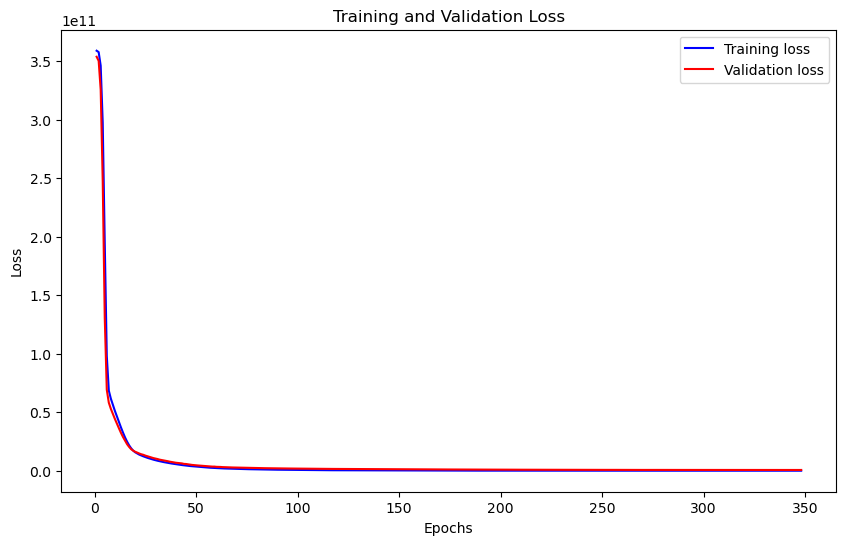

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

# 모델 구성
model = Sequential([
    Dense(HIDDEN_SIZE, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    #Dropout(0.1),
    #Dense(64, activation='relu'),
    #Dropout(0.1),
    #Dense(64, activation='relu'),
    #Dropout(0.1),
    #Dense(32, activation='relu'),
    #Dropout(0.1),
    Dense(32, activation='relu'),
    #Dropout(0.1),
    Dense(32, activation='relu'),
    #Dropout(0.1),
    Dense(5, activation='linear')
])

# 모델 컴파일
optimizer = 'adam'
loss = 'mse'
model.compile(optimizer=optimizer, loss=loss)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(patience=20)

# 모델 훈련
history = model.fit(X_train_scaled, y_train,
          validation_split = 0.2, 
          verbose = 1,
          batch_size = BATCH_SIZE, 
          epochs = EPOCHS, 
          callbacks = [early_stopping])

# 테스트 데이터로 모델 평가
loss = model.evaluate(X_test_scaled, y_test, batch_size=BATCH_SIZE)
print(f"loss : {loss}")

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
y_pred = model.predict(X_test_scaled)

if TARGET == 'Close' :
    target, predict = "종가", "예측가"
else :
    target, predict = "변화율", "예측 변화율"
for i in range(5) :
    print(f"{target} : {y_test[i]} / {predict} : {y_pred[i]}")

8/8 [==============================] - 0s 2ms/step
종가 : [520000 528000 524000 522000 523000] / 예측가 : [530664.4  531332.   530854.44 531557.5  530685.6 ]
종가 : [540000 545000 536000 538000 542000] / 예측가 : [524096.47 524779.3  524237.7  524424.75 523466.9 ]
종가 : [ 968000  953000  953000  984000 1008000] / 예측가 : [985855.06 986657.4  986124.7  985535.94 982698.7 ]
종가 : [789000 788000 768000 751000 754000] / 예측가 : [780529.9  781181.   780735.56 780319.   778014.6 ]
종가 : [711000 700000 680000 676000 666000] / 예측가 : [690827.3  691645.94 691145.1  691432.44 690065.06]


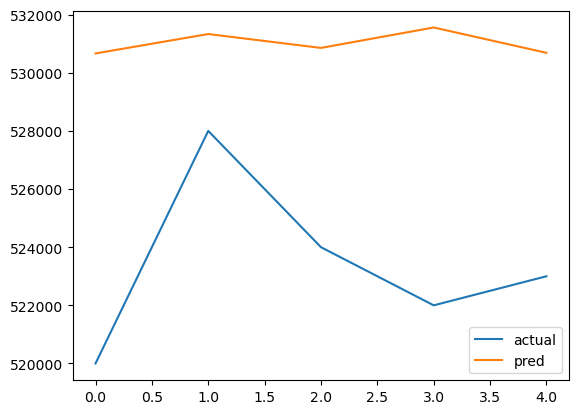

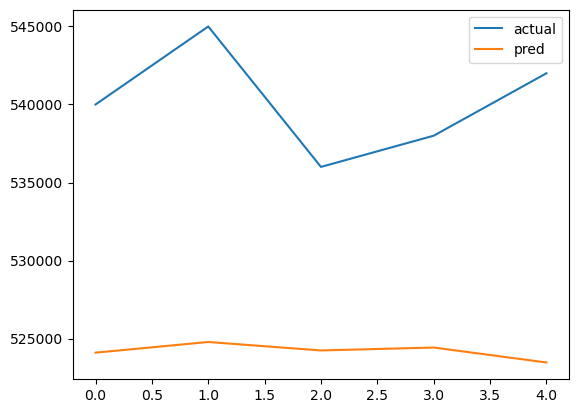

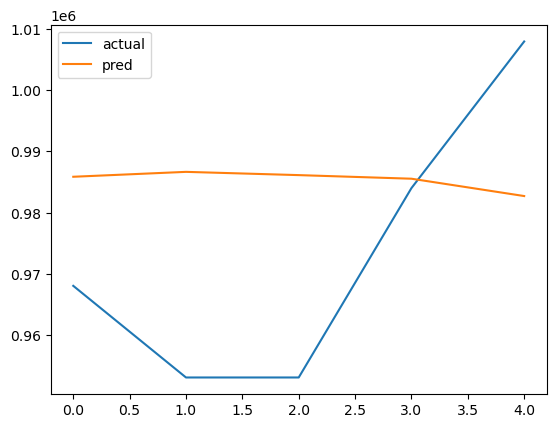

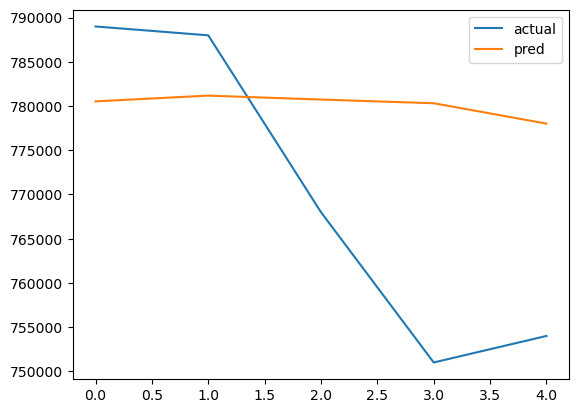

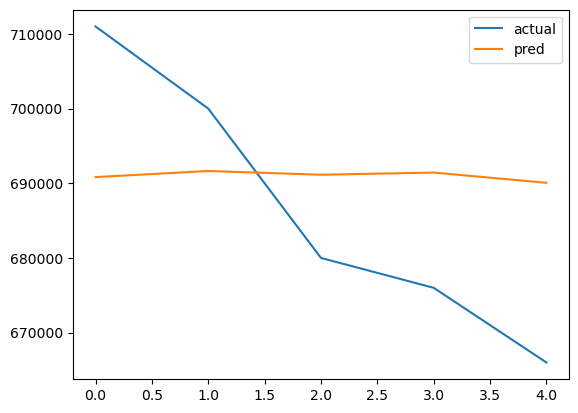

In [11]:
for i in range(5) :
    res = pd.DataFrame({'actual' : y_test[i], 'pred' : y_pred[i]})
    res.plot()

## Predict Future

In [12]:
X_new = data.tail(SEQ_SIZE).values
X_new = X_new.reshape(1, X_new.shape[0]*X_new.shape[1])

X_new_scaled = scaler.transform(X_new)

In [13]:
y_pred = model.predict(X_new_scaled)
y_pred

1/1 [==============================] - 0s 56ms/step


array([[252483.52, 252694.02, 252507.58, 253258.69, 252488.02]],
      dtype=float32)

In [14]:
if TARGET == 'Change' :
    endPrice = data['Close'].iloc[-1]
    pred_close = []

    for i in y_pred[0] :
        endPrice = endPrice + endPrice*i
        pred_close.append(endPrice)

    y_pred = np.array(pred_close).reshape(1, PRED_SIZE)
    
else :
    pass

y_pred

array([[252483.52, 252694.02, 252507.58, 253258.69, 252488.02]],
      dtype=float32)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


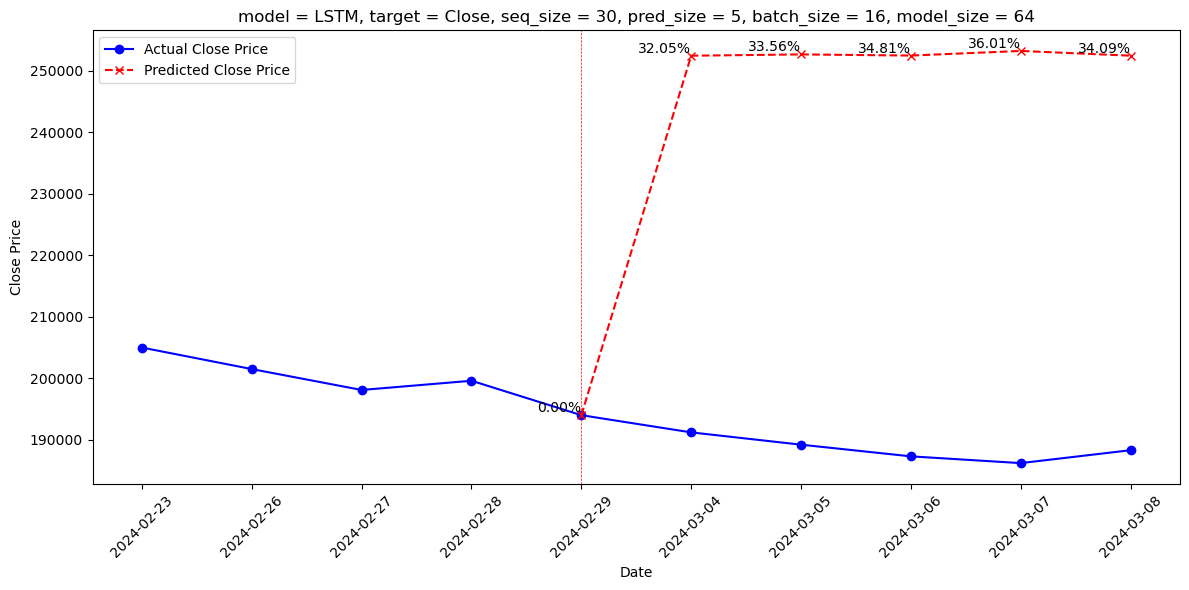

Average Error Rate: 34.11%


In [15]:
import FinanceDataReader as fdr

code_dict = {'sk' : '000660', 'kb' : '105560', 'ct' : '068270', 'sm' : '041510', 'nc' : '036570'}

label_df = fdr.DataReader(code_dict[STOCK], start = '2024-03-01', end = '2024-03-30').reset_index()
label_value = [value for value in data.tail(5)["Close"]] + list(np.array(label_df.head(PRED_SIZE)["Close"]))

# Prediction
pred = [np.NaN for i in range(4)] + [label_value[4]] + y_pred[0].tolist()
pred = np.array(pred).reshape(PRED_SIZE+5)

# 날짜 데이터
period = label_df["Date"]
period = [idx for idx in data.tail(5)["Change"].index]+[str(date.date()) for date in label_df.head(PRED_SIZE)["Date"].tolist()]

# 오차율 계산
error_rate = np.abs((label_value - pred) / label_value) * 100

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(period, label_value, marker='o', color='blue', label='Actual Close Price')
plt.plot(period, pred, marker='x', color='red', linestyle='--', label='Predicted Close Price')

# 오차율 표시
for date, lbl, prd, err in zip(period, label_value, pred, error_rate):
    plt.text(date, prd, f'{err:.2f}%', color='black', ha='right', va='bottom')

plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(f'model = LSTM, target = {TARGET}, seq_size = {SEQ_SIZE}, pred_size = {PRED_SIZE}, batch_size = {BATCH_SIZE}, model_size = {HIDDEN_SIZE}')
plt.axvline(x ='2024-02-29', color='red', linestyle='--', linewidth = 0.5)
plt.legend()
plt.tight_layout()
plt.show()

# 오차율
error_rate_dict = dict(zip(period[5:], error_rate[5:]))

# 평균 오차율
average_error_rate = np.mean(error_rate[5:15])

print(f"Average Error Rate: {average_error_rate:.2f}%")